# Exploration of Volterra ODE system

(by Sean Cowan)

This notebook explores the Volterra system of ODEs, defined as:

$$
\begin{array}{l}
\frac{d x_1}{d t} &= 2 x_1\left(1-x_2\right) \\
\frac{d x_2}{d t} &= -x_2\left(1-x_1\right)
\end{array}
$$

where $x_{01} \in 1+[-0.05,0.05], \quad x_{02} \in 3+[-0.05,0.05] \quad$ at $t=0$. It is shown that the implementation of Taylor models can predict the reachable set of states given an initial perturbation within the specified domain well. This is verified against figures in Makino (2003) as well as a Monte Carlo simulation.

[1] Berz, Martin, and Kyoko Makino. "Suppression of the wrapping effect by Taylor model-based verified integrators: Long-term stabilization by shrink wrapping." Int. J. Diff. Eq. Appl 10 (2005): 385-403.


## Importing stuff

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as col
from scipy.integrate import solve_ivp

from pyaudi import gdual_double as gdual, taylor_model, int_d
from plotting_functions import plot_n_to_2_solution_enclosure, sample_on_square_boundary

## Integration function

In [2]:
def rk4_t(f, t0, y0, th):
    t = th
    timesteps = [(th[i + 1] - th[i]).item() for i in range(len(th) - 1)]
    y = np.array([[type(y0[0])] * np.size(y0)] * (len(t)))
    y[0] = y0
    for n in range(len(t) - 1):
        # start_time = time.time()
        h = timesteps[n]
        xi1 = y[n]
        f1 = f(t[n], xi1)
        xi2 = y[n] + (h / 2.0) * f1
        f2 = f(t[n + 1], xi2)
        xi3 = y[n] + (h / 2.0) * f2
        f3 = f(t[n + 1], xi3)
        xi4 = y[n] + h * f3
        f4 = f(t[n + 1], xi4)
        y[n + 1] = y[n] + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
    return y

## Problem definition

Here, we define the system of ODEs and give initial conditions. Furthermore, a domain size is defined that indicates the validity domain of the Taylor model, indicating what initial uncertainty can be given.

In [3]:
def eom_volterra(t, y):
    return np.array([2 * y[0] * (1 - y[1]), -1 * y[1] * (1 - y[0])])

# The initial conditions
ic = [1, 3]
initial_time = 0.0
final_time = 5.488138468035
domain_size = 0.05

##  Numerical propagation

We create a high tolerance numerical solution for visualization purposes

In [4]:
y_num_viz = solve_ivp(
    eom_volterra, (initial_time, final_time), ic, method="RK45", rtol=1e-13, atol=1e-13
)

## Taylor model propagation

### Verification against Makino (2003)

Here, we take a small, fixed step-size and compare some of the solution enclosures against those in Makino (2003). First, we propagate the Taylor models with a given order and time history with $\Delta t = 0.01$.

In [5]:
order = 18
time_history = np.linspace(0.0, 5.45, 546)
colors = sns.color_palette("Blues", as_cmap=True)

symbols = ["x1", "x2"]
ic_g = [gdual(ic[0], symbols[0], order), gdual(ic[1], symbols[1], order)]
ic_tm = [
    taylor_model(
        ic_g[i],
        int_d(0.0, 0.0),
        {symbols[i]: ic[i]},
        {symbols[i]: int_d(ic[i] - domain_size / 2, ic[i] + domain_size / 2)},
    )
    for i in range(2)
]

# We call the numerical integrator, this time it will compute on Taylor models
y_tm = rk4_t(eom_volterra, initial_time, ic_tm, time_history)

Now we plot the solution enclosure for a number of specified indices (and therefore timesteps).

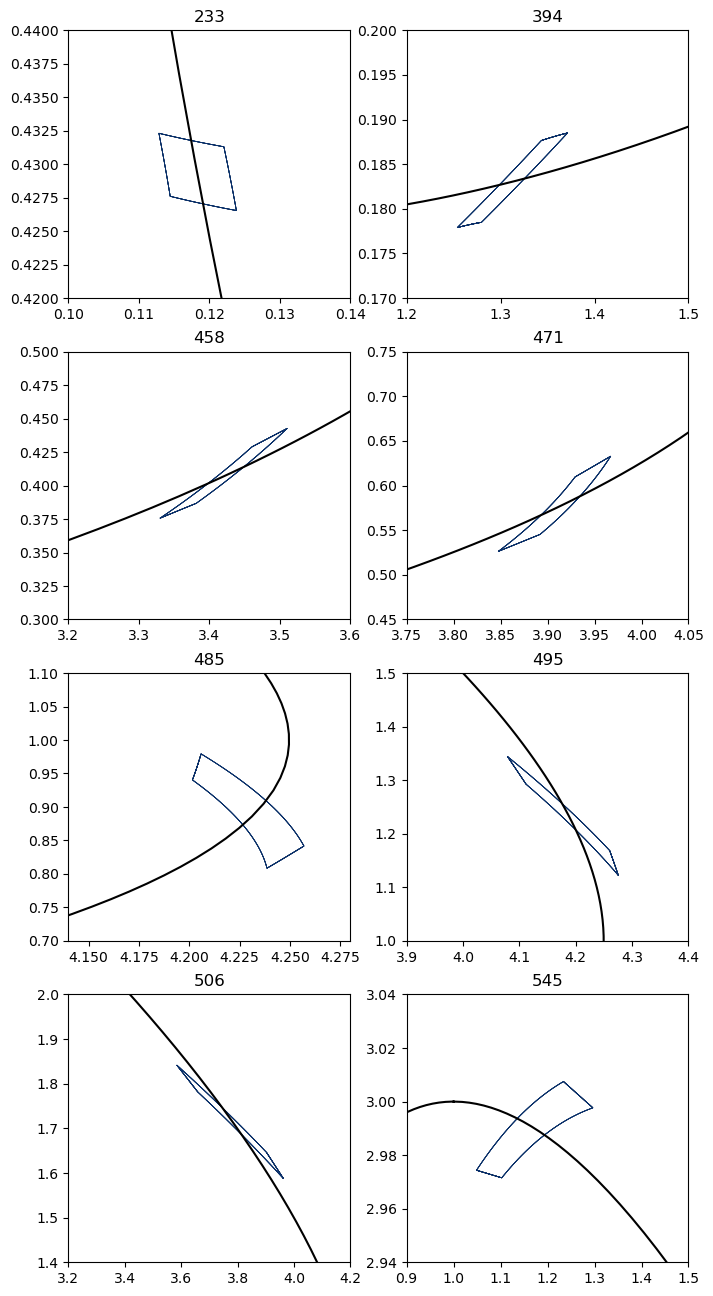

In [6]:
indices_to_evaluate = [233, 394, 458, 471, 485, 495, 506, 545]

fig = plt.figure(figsize=(8, 16))

domain_per_index = {233: ([0.1, 0.14], [0.42, 0.44]), 394: ([1.2, 1.5], [0.17, 0.2]), 458: ([3.2, 3.6], [0.3, 0.5]), 471: ([3.75, 4.05], [0.45, 0.75]), 485: ([4.14, 4.28], [0.7, 1.1]), 495: ([3.9, 4.4], [1, 1.5]), 506: ([3.2, 4.2], [1.4, 2]), 545: ([0.9, 1.5], [2.94, 3.04])}

rgb_color = col.rgb2hex(colors(400))
rem_bounds = []

y_num = rk4_t(eom_volterra, initial_time, ic, time_history)

for it, index in enumerate(indices_to_evaluate):
    ax = fig.add_subplot(4,2,it+1)
    ax.set_title(f'{index}')
    
    for it2, y_step in enumerate(y_tm):
    
        if it2 == index:
            x1_tm = y_step[0]
            x2_tm = y_step[1]
            rem_bounds.append((x1_tm.rem_bound, x2_tm.rem_bound))
    
            ax = plot_n_to_2_solution_enclosure(x1_tm, x2_tm, ax=ax, color=rgb_color, resolution=1000)
    
    ax.plot(y_num_viz.y[0], y_num_viz.y[1], c="k")
    
    xlim = domain_per_index[index][0]
    ylim = domain_per_index[index][1]
    custom_limit = None
    buffer = 0.1
    if custom_limit is not None:
        xlim = [y_num[custom_limit, 0] - buffer, y_num[custom_limit, 0] + buffer]
        ylim = [y_num[custom_limit, 1] - buffer, y_num[custom_limit, 1] + buffer]
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Finally, we also add a Monte Carlo to verify independently of Makino (2003) that out Taylor model enclosure is valid.

NOTE: Since we are using a numerical integrator, of which the integration error is not bounded, At very high precisions the Monte Carlo samples may fall outside the remainder bound in certain cases.

In [7]:
order = 5 # This order is chosen to visualize the verification better

symbols = ["x1", "x2"]
ic_g = [gdual(ic[0], symbols[0], order), gdual(ic[1], symbols[1], order)]
ic_tm = [
    taylor_model(
        ic_g[i],
        int_d(0.0, 0.0),
        {symbols[i]: ic[i]},
        {symbols[i]: int_d(ic[i] - domain_size / 2, ic[i] + domain_size / 2)},
    )
    for i in range(2)
]

# We call the numerical integrator, this time it will compute on Taylor models
y_tm = rk4_t(eom_volterra, initial_time, ic_tm, time_history)

It 1000/1000

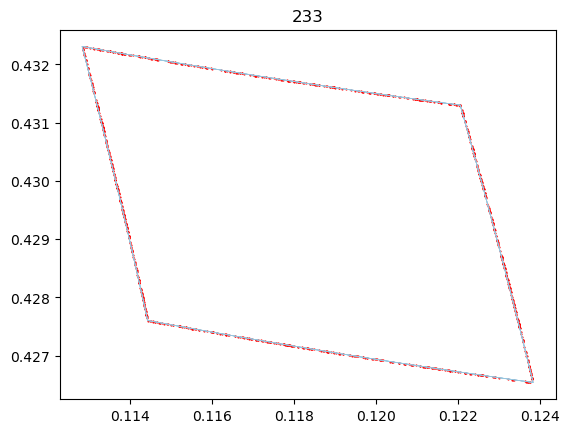

In [8]:
index = 233

fig2 = plt.figure()

domain_per_index = {233: ([0.1, 0.14], [0.42, 0.44]), 394: ([1.2, 1.5], [0.17, 0.2]), 458: ([3.2, 3.6], [0.3, 0.5]), 471: ([3.75, 4.05], [0.45, 0.75]), 485: ([4.14, 4.28], [0.7, 1.1]), 495: ([3.9, 4.4], [1, 1.5]), 506: ([3.2, 4.2], [1.4, 2]), 545: ([0.9, 1.5], [2.94, 3.04])}

rgb_color = col.rgb2hex(colors(100))
rem_bounds = []

y_num = rk4_t(eom_volterra, initial_time, ic, time_history)

ax2 = fig2.add_subplot(111)
ax2.set_title(f'{index}')

for it2, y_step in enumerate(y_tm):

    if it2 == index:
        x1_tm = y_step[0]
        x2_tm = y_step[1]
        rem_bounds.append((x1_tm.rem_bound, x2_tm.rem_bound))

        ax2 = plot_n_to_2_solution_enclosure(x1_tm, x2_tm, ax=ax2, color=rgb_color, resolution=300)


xlim = domain_per_index[index][0]
ylim = domain_per_index[index][1]
custom_limit = None
buffer = 0.1
if custom_limit is not None:
    xlim = [y_num[custom_limit, 0] - buffer, y_num[custom_limit, 0] + buffer]
    ylim = [y_num[custom_limit, 1] - buffer, y_num[custom_limit, 1] + buffer]


# Monte Carlo
n_samples_mc = int(1e3)

seed2 = 2
rng2 = np.random.Generator(np.random.MT19937(seed2))
ic_mc = copy.deepcopy(ic)

ic_mc = sample_on_square_boundary(ic_mc, domain_size, n_samples_mc=n_samples_mc, rng=rng2)

for j in range(n_samples_mc):
    print(f"It {j+1}/{n_samples_mc}", end="\r", flush=True)
    current_ic = list(ic_mc[:, j])
    y_num = rk4_t(eom_volterra, initial_time, current_ic, time_history)

    x1 = y_num[index, 0]
    x2 = y_num[index, 1]
    ax2.scatter(x1, x2, c="r", s=0.3)